In [1]:
# Core
import pandas as pd
import numpy as np
from scipy.interpolate import CubicSpline

# Astronomy
from astropy.time import Time
from astropy.units import deg

# Utility
import os
from datetime import date
import time
from tqdm.auto import tqdm

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import Image

# Libraries for getting Alerce data out of ZTF2 database
import json
import psycopg2
from alerce.api import AlerceAPI

# MSE imports
from asteroid_element import load_ast_elt
from asteroid_integrate import calc_ast_pos_all
from candidate_element import orbital_element_batch
from asteroid_dataframe import load_ast_data, calc_ast_data, spline_ast_vec_dir, spline_ast_vec_df
from ztf_data import load_ztf_det_all, make_ztf_near_elt
from ztf_ast import load_ztf_nearest_ast, ztf_nearest_ast, calc_hit_freq
from ztf_data_viz import cdf_nearest_dist
from ztf_data_viz import ztf_obs_by_month, plot_cdf_uncond, plot_cdf_cond, plot_dist, plot_rel_density, plot_hit_freq

from utils import range_inc
from astro_utils import date_to_mjd, mjd_to_date
from astro_utils import deg2dist, dist2deg

In [2]:
# Set plot style variables
mpl.rcParams['figure.figsize'] = [16.0, 10.0]
mpl.rcParams['font.size'] = 16

### Load Detections from ZTF2 Database

In [3]:
ztf, mjd_unq = load_ztf_det_all()

In [4]:
# Review DataFrame
ztf

,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,ux,uy,uz,mag_app,asteroid_prob
0,b'ZTF18acebhfp',676397301515010013,14490,58430.397303,41.357345,58.879488,0.387942,0.653853,0.649598,18.946699,0.865682
1,b'ZTF18abodmwk',596403415715010014,5831,58350.403414,30.969721,65.305308,0.358224,0.558644,0.748059,19.010401,0.855504
2,b'ZTF18abodmwk',626428345715010011,10614,58380.428345,30.969705,65.305294,0.358224,0.558644,0.748059,18.935900,0.855504
3,b'ZTF18abodmwk',630507595715015045,11250,58384.507593,30.969940,65.305305,0.358223,0.558645,0.748059,19.260401,0.855504
4,b'ZTF18abodmwk',618384965715010022,9040,58372.384965,30.969643,65.305179,0.358226,0.558644,0.748058,19.220200,0.855504
...,...,...,...,...,...,...,...,...,...,...,...
5697957,b'ZTF20aareruw',1151532523515015015,97109,58905.532523,253.007910,55.485537,-0.165587,-0.169403,0.971537,19.192400,0.608023
5697958,b'ZTF20aarerwx',1151533002615015009,97110,58905.533009,232.886408,53.509617,-0.358833,-0.115301,0.926253,19.687099,0.559474
5697959,b'ZTF20aarerww',1151533002115010003,97110,58905.533009,236.167899,54.618457,-0.322375,-0.116973,0.939357,19.957001,0.392662
5697960,b'ZTF20aarervr',1151526063515015015,97098,58905.526065,286.235286,33.876902,0.232120,-0.509626,0.828494,19.049299,0.517241


In [5]:
# Review data types
ztf.dtypes

ObjectID            |S12
CandidateID        int64
TimeStampID        int32
mjd              float64
ra               float64
dec              float64
ux               float64
uy               float64
uz               float64
mag_app          float64
asteroid_prob    float64
dtype: object

In [6]:
# Sanity check: we should be able to recover the mjd of an observation by indexing into mjd_unq
assert np.all(mjd_unq[ztf.TimeStampID] == ztf.mjd)

### Summarize Observations by Month

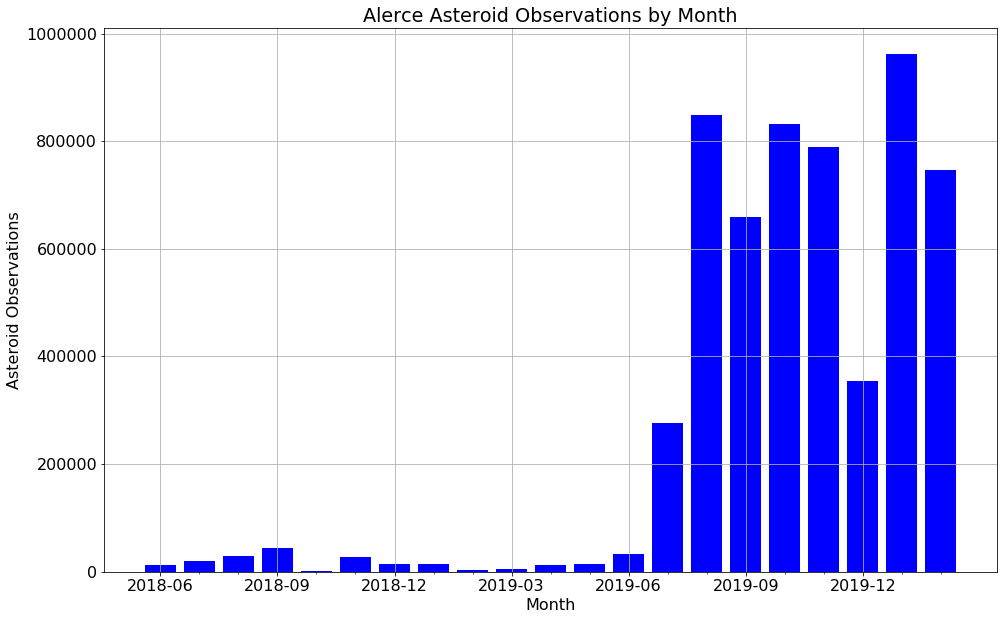

In [7]:
# Generate bar chart
# ztf_obs_by_month(ztf)

# Display the bar chart
Image(filename='../figs/ztf/ztf_ast_per_month.png')

### Extract key Data from ZTF Frame

In [8]:
# Extract mjd, ra, and dec of the ZTF observations as arrays of astropy angles
# mjd_ztf = ztf.mjd.values
# ra_ztf = ztf.ra.values
# dec_ztf = ztf.dec.values

In [9]:
# Extract directions of the ZTF observations as an Nx3 array
# u_ztf = ztf[['ux', 'uy', 'uz']].values

### Load MSE Calculated Asteroid Directions for Comparison to ZTF

In [10]:
# Date range in ZTF data
mjd_min = np.min(mjd_unq)
mjd_max = np.max(mjd_unq)
dt_min = mjd_to_date(mjd_min)
dt_max = mjd_to_date(mjd_max)
print(f'ZTF mjd range : {mjd_min:9.3f} to {mjd_max:9.3f}')
print(f'ZTF date range: {dt_min} to {dt_max}')

ZTF mjd range : 58270.170 to 58905.533
ZTF date range: 2018-06-01 to 2020-02-26


In [11]:
# Range of asteroids to compare to ZTF
n0: int = 0
n1: int = 1256000

# Observatory site
# site_name = 'palomar'

In [12]:
# Build splined positions and observations against unique observation times
# ast_pos, earth_pos, ast_dir = spline_ast_vec_dir(n0=n0, n1=n1, mjd=mjd_unq, site_name=site_name)

In [13]:
# Get asteroid numbers in selected range
ast_elt = load_ast_elt()
ast_mask = (n0 <= ast_elt.Num) & (ast_elt.Num < n1)
ast_nums = ast_elt.Num[ast_mask].values.astype(np.int32)
print(f'Orbital elements available for {ast_nums.size} asteroids with numbers {n0} to {n1}.')

Orbital elements available for 733489 asteroids with numbers 0 to 1256000.


In [14]:
# Find nearest asteroid to ZTF observations
thresh_deg = 180.0
# ztf = ztf_nearest_ast(ztf=ztf, n0=n0, n1=n1, thresh_deg=thresh_deg, regen=False)
ztf = load_ztf_nearest_ast(n0=n0, n1=n1)

In [15]:
ztf

,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,ux,uy,uz,mag_app,asteroid_prob,nearest_ast_num,nearest_ast_dist,ast_ra,ast_dec,ast_ux,ast_uy,ast_uz
0,b'ZTF18acebhfp',676397301515010013,14490,58430.397303,41.357345,58.879488,0.387942,0.653853,0.649598,18.946699,0.865682,1208789,0.005029,41.396388,58.592038,0.390926,0.655662,0.645976
1,b'ZTF18abodmwk',596403415715010014,5831,58350.403414,30.969721,65.305308,0.358224,0.558644,0.748059,19.010401,0.855504,1227812,0.024428,33.729101,64.536183,0.357570,0.578168,0.733393
2,b'ZTF18abodmwk',626428345715010011,10614,58380.428345,30.969705,65.305294,0.358224,0.558644,0.748059,18.935900,0.855504,1169677,0.015510,29.207596,64.817653,0.371401,0.550472,0.747691
3,b'ZTF18abodmwk',630507595715015045,11250,58384.507593,30.969940,65.305305,0.358223,0.558645,0.748059,19.260401,0.855504,1251951,0.012386,30.227911,65.945543,0.352183,0.551505,0.756181
4,b'ZTF18abodmwk',618384965715010022,9040,58372.384965,30.969643,65.305179,0.358226,0.558644,0.748058,19.220200,0.855504,1246591,0.025343,34.169666,64.771024,0.352659,0.579473,0.734740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5459014,b'ZTF20aareruw',1151532523515015015,97109,58905.532523,253.007910,55.485537,-0.165587,-0.169403,0.971537,19.192400,0.608023,1102168,0.036944,253.707834,53.408139,-0.167230,-0.205583,0.964246
5459015,b'ZTF20aarerwx',1151533002615015009,97110,58905.533009,232.886408,53.509617,-0.358833,-0.115301,0.926253,19.687099,0.559474,1028157,0.084402,224.967815,54.919912,-0.406617,-0.047125,0.912382
5459016,b'ZTF20aarerww',1151533002115010003,97110,58905.533009,236.167899,54.618457,-0.322375,-0.116973,0.939357,19.957001,0.392662,539940,0.052254,240.693936,56.155104,-0.272611,-0.115218,0.955200
5459017,b'ZTF20aarervr',1151526063515015015,97098,58905.526065,286.235286,33.876902,0.232120,-0.509626,0.828494,19.049299,0.517241,1246304,0.014054,285.998189,34.657915,0.226704,-0.499251,0.836274


### Analyze Distribution of Nearest Asteroid Distance

In [16]:
# Convert threshold from degrees to cartesian distance
thresh_close_sec = 2.0
thresh_close_deg = thresh_close_sec / 3600.0
thresh_close_dist = deg2dist(thresh_close_deg)

# Count number of asteroids matched against
ast_count = ast_nums.size
# Number of rows in data
N_obs = ztf.shape[0]

# Count frequency of matches
is_close = ztf.nearest_ast_dist < thresh_close_dist
match_frac_obs = np.mean(is_close)
match_frac_ran = cdf_nearest_dist(dist=thresh_close_dist, n=ast_count)
match_count_obs = np.sum(is_close)
match_count_ran = N_obs * match_frac_ran
match_ratio = match_frac_obs / match_frac_ran
# Compare this to mean asteroid probability according to ZTF
mean_ast_prob = np.mean(ztf.asteroid_prob)

print(f'Testing {ast_count} asteroids at threshold = {thresh_close_sec} arc sec.')
print(f'\nObserved match count    = {match_count_obs:8d}')
print(f'Random   match count    = {match_count_ran:8.0f}')
print(f'Observed match fraction = {match_frac_obs:8.6f}')
print(f'Random   match fraction = {match_frac_ran:8.6f}')
print(f'Ratio =  {match_ratio:8.6f}')
print(f'\nMean asteroid probability = {mean_ast_prob:8.6f}')

Testing 733489 asteroids at threshold = 2.0 arc sec.

Observed match count    =  3747726
Random   match count    =       98
Observed match fraction = 0.657731
Random   match fraction = 0.000017
Ratio =  38151.258703

Mean asteroid probability = 0.939832


In [17]:
# Set some thresholds in degrees
thresh_one_min = 1.0 / 60.0
thresh_ten_sec = 10.0 / 3600.0
thresh_two_sec = 2.0 / 3600
thresh_one_sec = 1.0 / 3600

## Plot Histograms of Frequency vs. Theoretical CDF

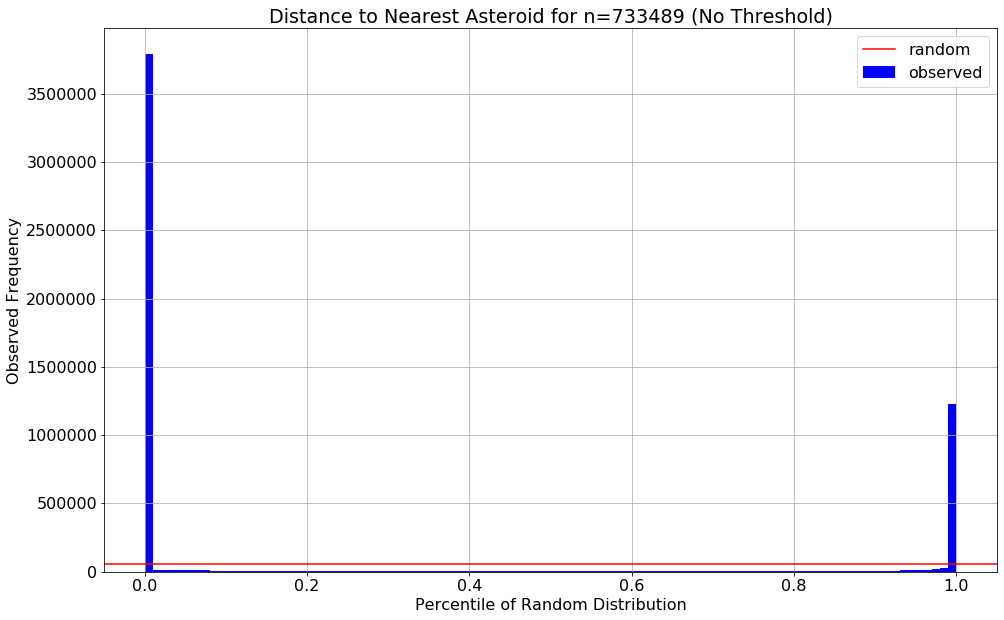

In [18]:
# Plot the full unconditional distribution
fig, ax = plot_cdf_uncond(ztf=ztf, n=ast_count, bins=100)

In [19]:
# Plot the conditional distribution at a threshold of 1.0 degrees
# fig, ax = plot_cdf_cond(ztf=ztf, n=ast_count, thresh_deg=1.0, bins=20)

In [20]:
# Plot the conditional distribution at a threshold of 1 arc minute
# fig, ax = plot_cdf_cond(ztf=ztf, n=ast_count, thresh_deg=thresh_one_min, bins=20)

In [21]:
# Plot the conditional distribution at a threshold of 10 arc seconds
# fig, ax = plot_cdf_cond(ztf=ztf, n=ast_count, thresh_deg=thresh_ten_sec, bins=100)

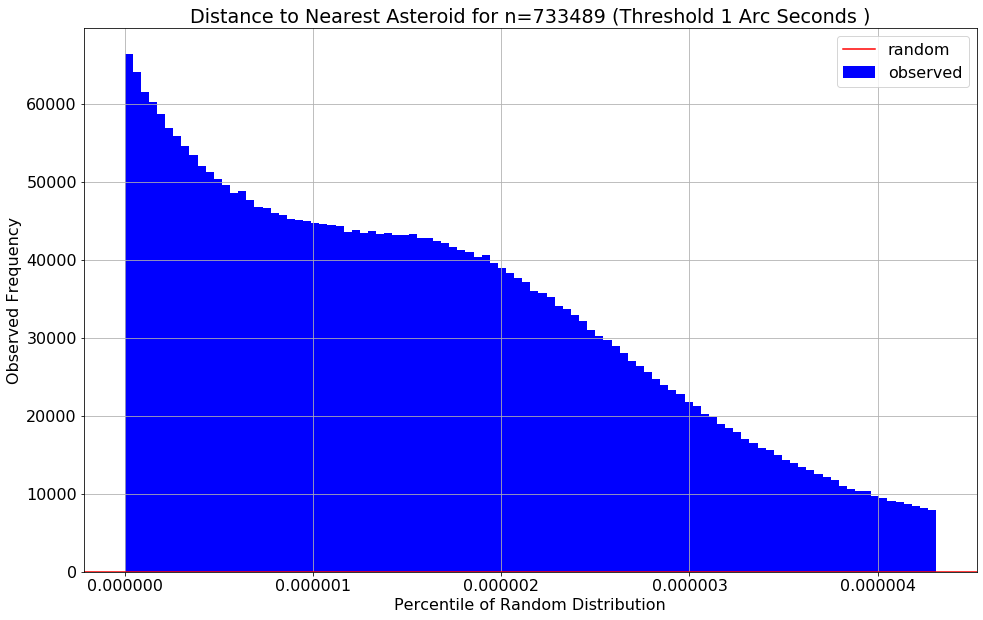

In [22]:
# Plot the conditional distribution at a threshold of 1 arc seconds
fig, ax = plot_cdf_cond(ztf=ztf, n=ast_count, thresh_deg=thresh_one_sec, bins=100)

## Plot Histograms of Frequency vs. Distance in Degrees or Arc Seconds

In [23]:
# fig, ax = plot_dist(ztf, n=ast_count, thresh_deg=1.0, bins=100)

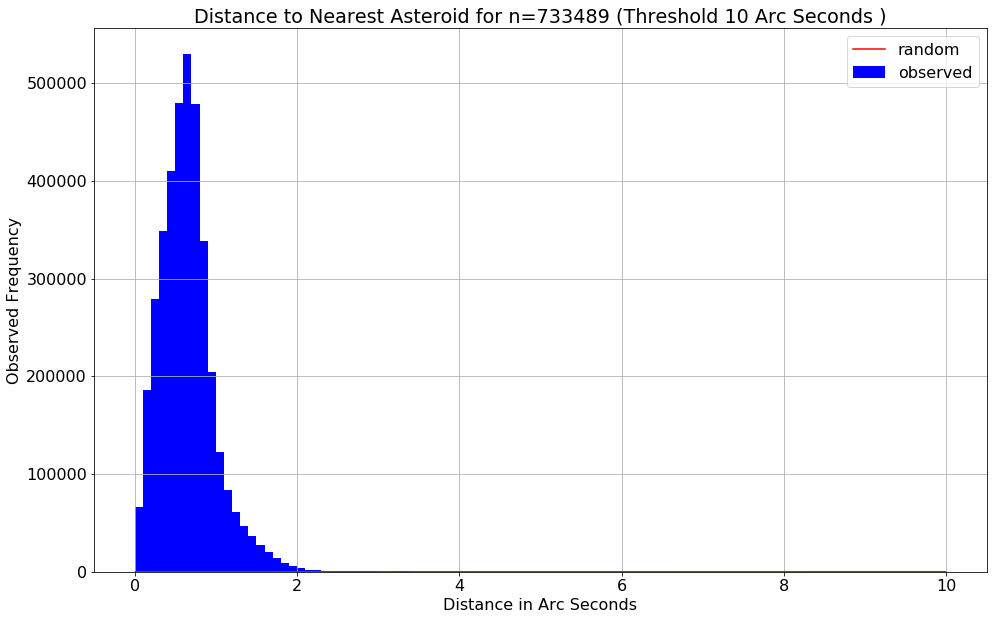

In [24]:
fig, ax = plot_dist(ztf, n=ast_count, thresh_deg=thresh_ten_sec, bins=100)

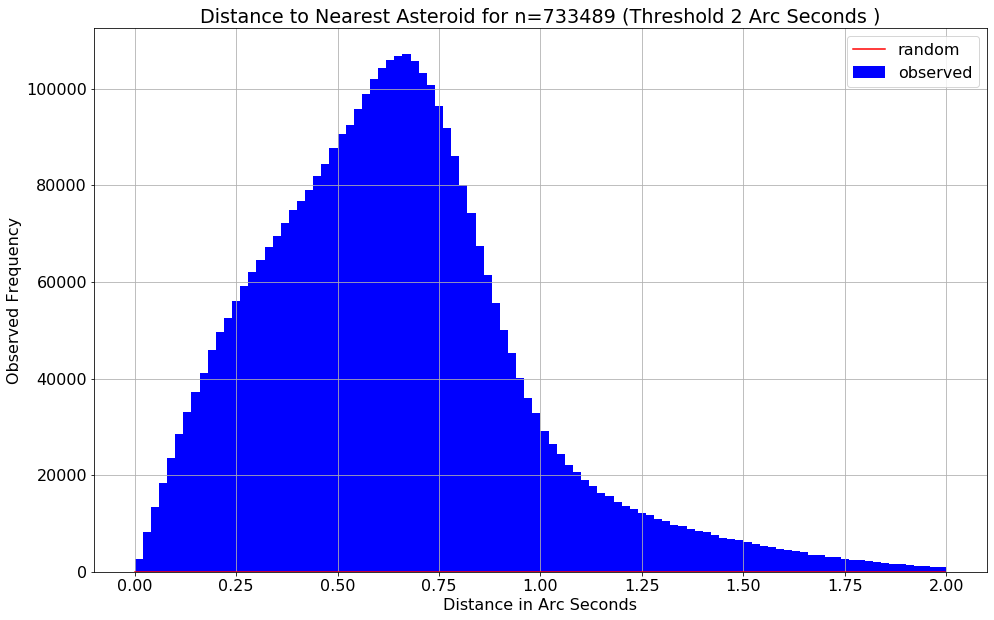

In [25]:
fig, ax = plot_dist(ztf, n=ast_count, thresh_deg=thresh_two_sec, bins=100)

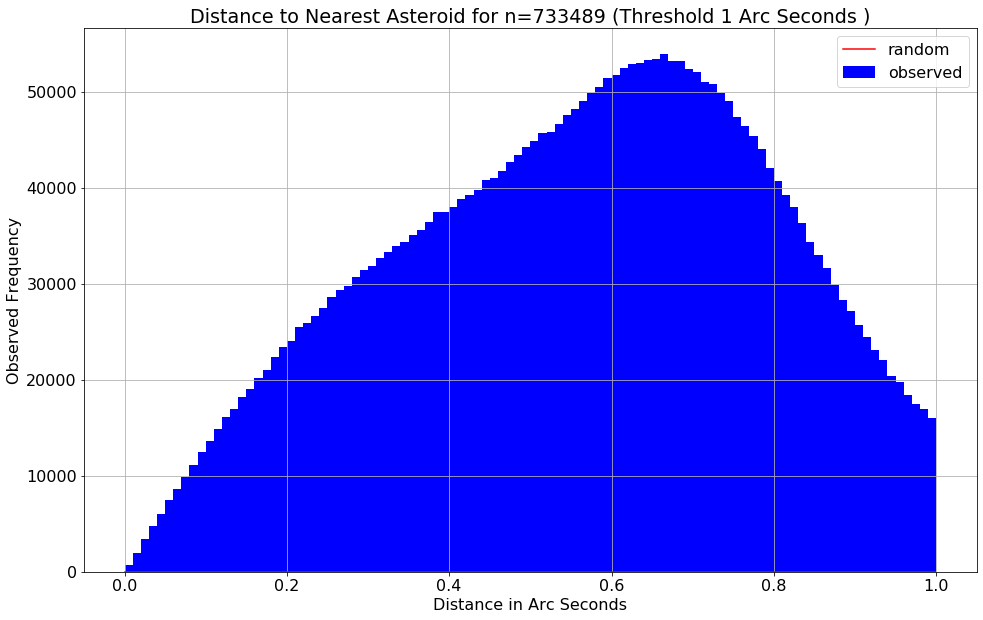

In [26]:
fig, ax = plot_dist(ztf, n=ast_count, thresh_deg=thresh_one_sec, bins=100)

## Plot Absolute & Relative Density to Theoretical Distribution

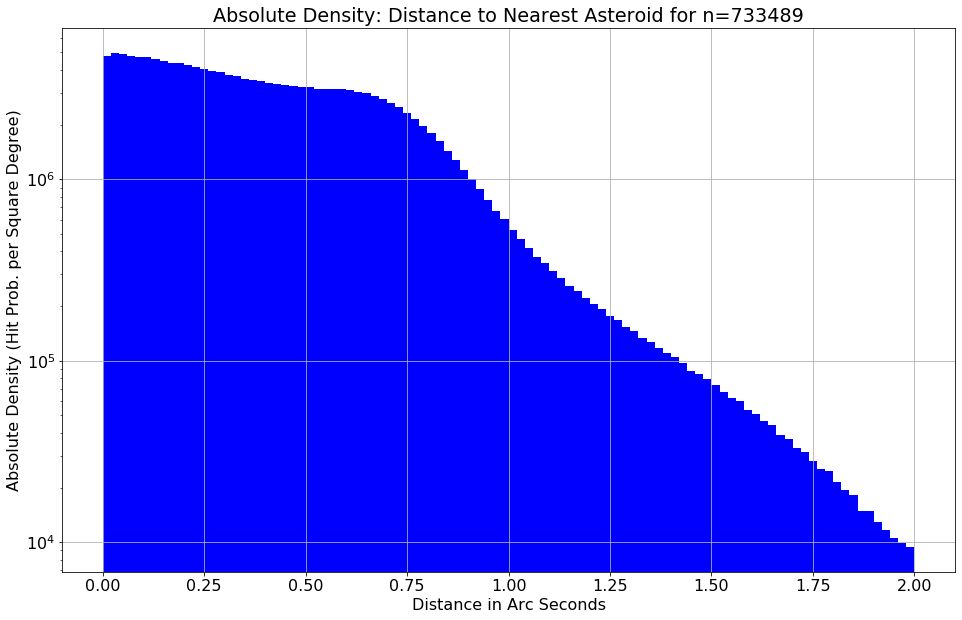

In [27]:
fig, ax = plot_rel_density(ztf, n=ast_count, thresh_deg=thresh_two_sec, bins=100, chart_type='abs')

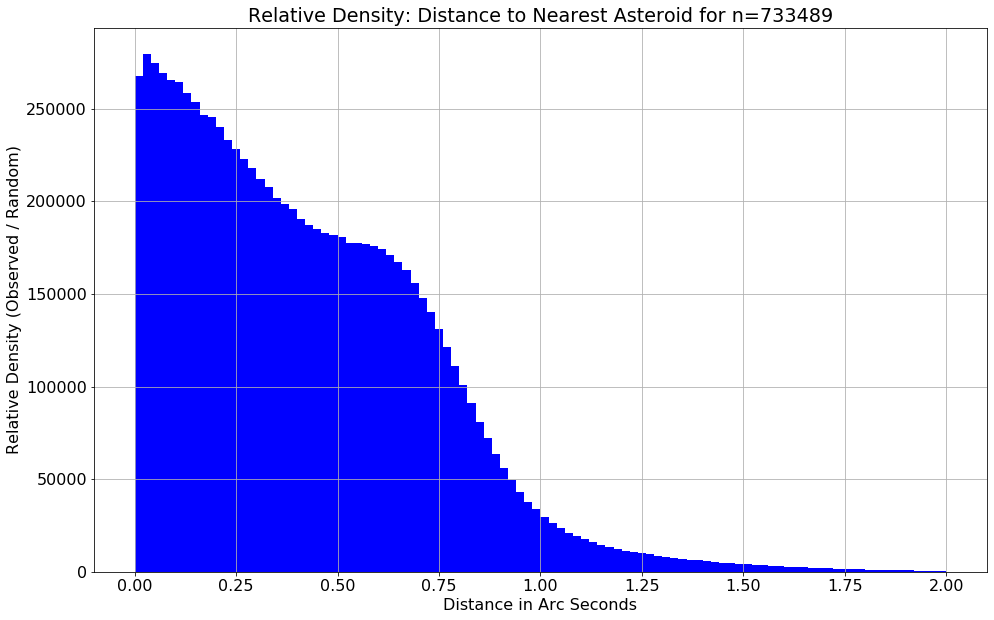

In [28]:
fig, ax = plot_rel_density(ztf, n=ast_count, thresh_deg=thresh_two_sec, bins=100, chart_type='rel')

### Explore Observations that are Close to One Asteroid

In [29]:
# Mask for entries that are close, as defined by above threshold
is_close = (ztf.nearest_ast_dist < thresh_close_dist)
# is_close = (ztf.nearest_ast_dist < thresh_close_dist) & (ztf.nearest_ast_num > 1e6)
ztfc = ztf[is_close].copy()

# Additional columns with distance in arc seconds
nearest_ast_arc_sec = dist2deg(ztfc.nearest_ast_dist) * 3600.0
# ztfc['nearest_ast_arc_sec'] = nearest_ast_arc_sec
col_num = ztfc.columns.get_loc('nearest_ast_dist')+1
ztfc.insert(loc=col_num, column='nearest_ast_arc_sec', value=nearest_ast_arc_sec)

In [30]:
ztfc

,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,ux,uy,uz,mag_app,asteroid_prob,nearest_ast_num,nearest_ast_dist,nearest_ast_arc_sec,ast_ra,ast_dec,ast_ux,ast_uy,ast_uz
602,b'ZTF18acqvjbw',689314713015015008,16951,58443.314711,63.025354,17.655906,0.432230,0.899796,-0.059531,18.519199,1.000000,135355,3.663691e-06,0.755691,63.025567,17.655961,0.432226,0.899798,-0.059531
649,b'ZTF18acrcadh',693308213515015017,17096,58447.308218,113.354357,33.962194,-0.328791,0.920837,0.209659,18.055201,1.000000,29076,8.997226e-07,0.185581,113.354324,33.962150,-0.328790,0.920837,0.209658
811,b'ZTF18abwawbk',621435901715015019,9621,58375.435903,32.348343,11.149056,0.828867,0.558563,-0.031414,19.707199,1.000000,101787,2.084178e-06,0.429892,32.348465,11.149059,0.828866,0.558565,-0.031414
833,b'ZTF18acurwxa',707509454415015012,18339,58461.509456,103.310341,27.540611,-0.204137,0.975586,0.080995,19.427401,1.000000,138763,4.068908e-06,0.839272,103.310581,27.540515,-0.204141,0.975585,0.080994
890,b'ZTF18acuiphp',707257536115015009,18272,58461.257535,48.496514,22.452973,0.612431,0.786949,0.075091,19.038000,0.976392,105289,3.491132e-06,0.720098,48.496726,22.453012,0.612428,0.786952,0.075091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5458886,b'ZTF20aarepii',1151522393415015017,97090,58905.522396,236.892710,-2.341055,-0.545753,-0.784135,0.295442,15.089800,1.000000,727,2.473898e-06,0.510278,236.892569,-2.341034,-0.545755,-0.784134,0.295442
5458889,b'ZTF20aareowa',1151522390315015003,97090,58905.522396,237.654792,-5.909325,-0.532176,-0.811960,0.239813,15.717300,1.000000,625,2.355026e-06,0.485759,237.654657,-5.909328,-0.532178,-0.811958,0.239813
5458890,b'ZTF20aareowm',1151521944715015006,97089,58905.521944,236.239354,-9.304550,-0.548413,-0.817041,0.178007,15.695800,1.000000,464,2.205903e-06,0.455000,236.239228,-9.304526,-0.548415,-0.817040,0.178007
5458895,b'ZTF20aareowf',1151521946215015005,97089,58905.521944,234.674482,-7.771349,-0.572910,-0.795468,0.197496,16.917900,1.000000,2879,4.163074e-06,0.858696,234.674242,-7.771368,-0.572914,-0.795466,0.197494


In [31]:
# Group results by asteroid number
close_by_ast = ztfc.groupby(ztfc.nearest_ast_num)
close_by_ast_count = close_by_ast.size()
close_ast_num = close_by_ast_count.index.values
close_ast_count = close_by_ast_count.values

# Count number of asteroids with matches over various counts
matches_over_5 = np.sum(close_ast_count >= 5)
matches_over_10 = np.sum(close_ast_count >= 10)
matches_over_20 = np.sum(close_ast_count >= 20)

# Report
print(f'Found {matches_over_5:6} asteroids with  5 or more close matches at {thresh_close_sec} arc seconds.')
print(f'Found {matches_over_10:6} asteroids with 10 or more close matches at {thresh_close_sec} arc seconds.')
print(f'Found {matches_over_20:6} asteroids with 20 or more close matches at {thresh_close_sec} arc seconds.')

Found 135377 asteroids with  5 or more close matches at 2.0 arc seconds.
Found 100508 asteroids with 10 or more close matches at 2.0 arc seconds.
Found  63746 asteroids with 20 or more close matches at 2.0 arc seconds.


In [32]:
thresh_deg = thresh_two_sec

In [33]:
    thresh_sec = thresh_deg / 3600.0
    ast_num, hit_count = calc_hit_freq(ztf=ztf, thresh_sec=thresh_sec)

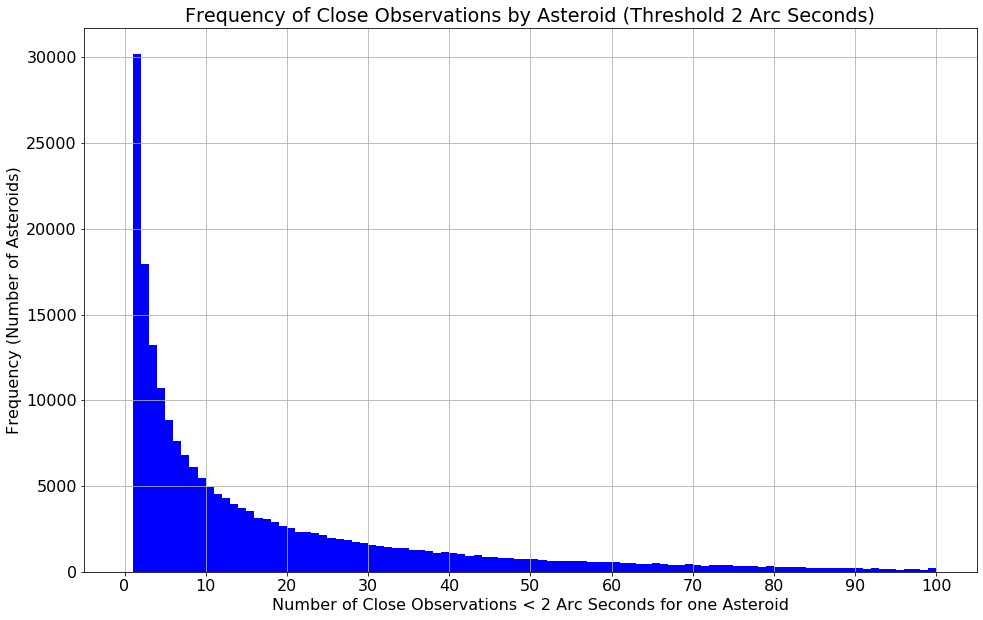

In [34]:
plot_hit_freq(ztf, n=ast_count, thresh_sec=2.0, is_cum=False, bins=100)

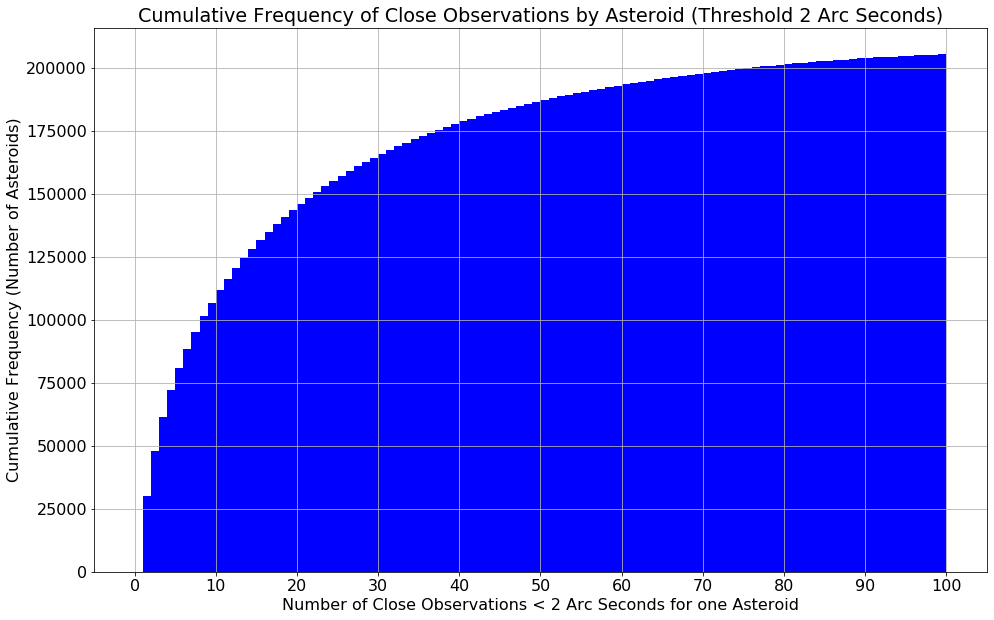

In [35]:
plot_hit_freq(ztf, n=ast_count, thresh_sec=2.0, is_cum=True, bins=100)

## Assemble Batch of Asteroids with Most Hits to Prototype Search

In [36]:
# Asteroid numbers and hit counts
ast_num, hit_count = calc_hit_freq(ztf=ztf, thresh_sec=2.0)

# Sort the hit counts in descending order and find the top 64
idx = np.argsort(hit_count)[::-1][0:64]

# Extract the asteroid number and hit count for this batch
ast_num_batch = ast_num[idx]
hit_count_batch = hit_count[idx]

In [37]:
# Mask for entries in this batch
is_in_batch = (ztf.nearest_ast_num == 0)
for ast_num in ast_num_batch:
    is_in_batch = is_in_batch | (ztf.nearest_ast_num == ast_num)
ztf64 = ztf[is_in_batch].copy()

In [38]:
ztf64

,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,ux,uy,uz,mag_app,asteroid_prob,nearest_ast_num,nearest_ast_dist,ast_ra,ast_dec,ast_ux,ast_uy,ast_uz
1656,b'ZTF19aaxbtge',883432713515015010,32606,58637.432720,349.617804,26.695540,0.878779,0.030983,0.476222,20.118000,0.528649,313521,0.006915,349.874445,26.372674,0.881970,0.032184,0.470206
3345,b'ZTF18abtyroq',893472970715010014,34299,58647.472975,354.025163,30.103966,0.860417,0.116893,0.496002,18.765600,0.932566,313521,0.003449,353.882857,29.949447,0.861533,0.113872,0.494767
6049,b'ZTF18abosfjn',896427220115015004,34661,58650.427222,355.296384,30.983843,0.854425,0.140274,0.500280,16.204500,0.916464,313521,0.003766,355.045433,31.000861,0.853957,0.136955,0.501997
6105,b'ZTF18abosfjn',896427220115015003,34661,58650.427222,355.296371,30.983844,0.854425,0.140274,0.500281,16.128201,0.916464,313521,0.003766,355.045433,31.000861,0.853957,0.136955,0.501997
6127,b'ZTF18abosfjn',896427220115015005,34661,58650.427222,355.296415,30.983890,0.854425,0.140275,0.500281,15.890600,0.916464,313521,0.003767,355.045433,31.000861,0.853957,0.136955,0.501997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5412924,b'ZTF20aaqvlmy',1150185755115015010,96635,58904.185752,41.868105,28.422819,0.654918,0.727863,0.203216,18.203100,1.000000,59123,0.000009,41.867533,28.422845,0.654924,0.727857,0.203219
5441789,b'ZTF20aarbpnr',1151112683815015002,96901,58905.112685,32.327962,34.020453,0.700369,0.629210,0.337013,18.458200,1.000000,73961,0.000007,32.327504,34.020497,0.700372,0.629205,0.337016
5441935,b'ZTF20aarbqkw',1151121034915015003,96919,58905.121030,25.806967,29.268916,0.785333,0.542902,0.297505,18.497400,1.000000,48453,0.000006,25.806544,29.268905,0.785336,0.542897,0.297507
5442136,b'ZTF20aarbqpo',1151121032115015000,96919,58905.121030,24.489749,25.919630,0.818493,0.515939,0.252736,18.606501,1.000000,31539,0.000003,24.489554,25.919688,0.818494,0.515937,0.252739


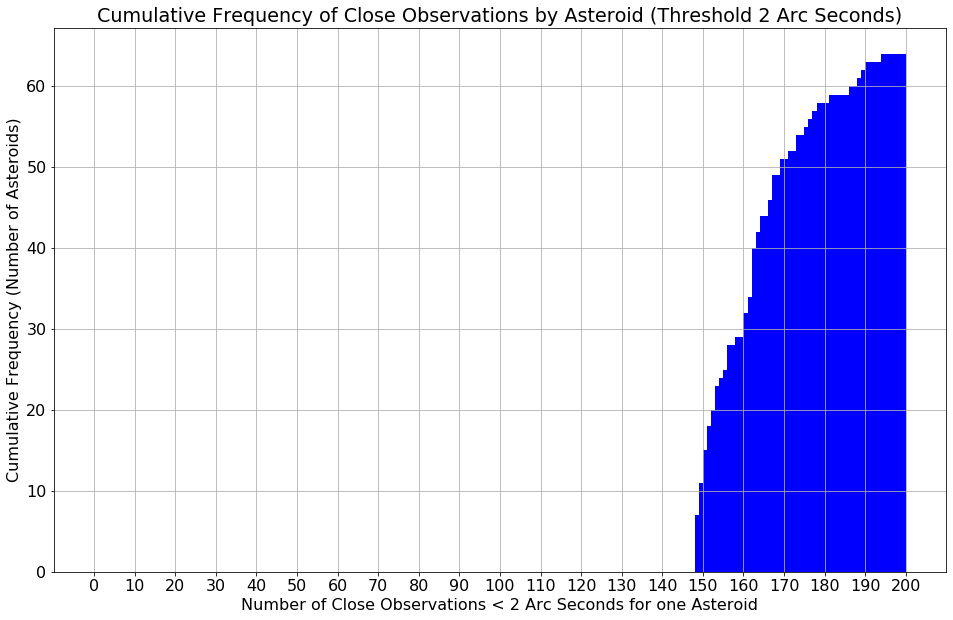

In [39]:
plot_hit_freq(ztf64, n=64, thresh_sec=2.0, bins=200, save_fig=False)

In [40]:
# Count number of hits and hit fraction 
batch_size = ztf64.shape[0]
batch_hits = np.sum(hit_count_batch)
batch_hit_frac = batch_hits / batch_size

# Report results
print(f'Found {batch_size} rows closest to 64 asteroids with the most hits.')
print(f'These asteroids have {batch_hits} hits at 2.0 arc seconds.')
print(f'Hit ratio = {batch_hit_frac:8.6f}')

Found 27783 rows closest to 64 asteroids with the most hits.
These asteroids have 10333 hits at 2.0 arc seconds.
Hit ratio = 0.371918


## Demonstrate calc_ast_data

In [41]:
# Inputs for demonstration
n0=1
n1=65
mjd0 = 58270.0
mjd1 = 58906.0
progbar=True

# Load data in this date range
df_ast_load, df_earth_load, df_sun_load = load_ast_data(n0=n0, n1=n1, mjd0=mjd0, mjd1=mjd1, progbar=progbar)

Loading asteroid data from n0=1 to n1=65 in 1 blocks...


In [42]:
# Orbital elements for first 64 asteroids (dict of numpy arrays)
elts = orbital_element_batch(np.arange(1, 65))

In [43]:
# Calculate vectors from these elements on the fly with calc_ast_data
df_ast_calc, df_earth_calc, df_sun_calc = calc_ast_data(elts=elts, mjd0=mjd0, mjd1=mjd1, element_id=None)

In [44]:
# Check agreement
cols_q = ['qx', 'qy', 'qz']
cols_v = ['vx', 'vy', 'vz']

dq_ast = df_ast_calc[cols_q] - df_ast_load[cols_q]
dv_ast = df_ast_calc[cols_v] - df_ast_load[cols_v]

dq_earth = df_earth_calc[cols_q] - df_earth_load[cols_q]
dv_earth = df_earth_calc[cols_v] - df_earth_load[cols_v]

dq_sun = df_sun_calc[cols_q] - df_sun_load[cols_q]
dv_sun = df_sun_calc[cols_v] - df_sun_load[cols_v]

# Report
# print(f'mean position difference = {np.mean(np.linalg.norm(dq, axis=1)):6.2e}')
print('Mean position difference in AU:')
print(f'asteroids: {np.mean(np.linalg.norm(dq_ast, axis=1)):6.2e}')
print(f'earth    : {np.mean(np.linalg.norm(dq_earth, axis=1)):6.2e}')
print(f'sun      : {np.mean(np.linalg.norm(dq_sun, axis=1)):6.2e}')

print('\nMean velocity difference in AU/day:')
print(f'asteroids: {np.mean(np.linalg.norm(dv_ast, axis=1)):6.2e}')
print(f'earth    : {np.mean(np.linalg.norm(dv_earth, axis=1)):6.2e}')
print(f'sun      : {np.mean(np.linalg.norm(dv_sun, axis=1)):6.2e}')

Mean position difference in AU:
asteroids: 3.13e-07
earth    : 3.07e-12
sun      : 1.52e-15

Mean velocity difference in AU/day:
asteroids: 1.24e-09
earth    : 5.31e-14
sun      : 1.92e-18


## Brightness of Hits

In [45]:
ztf

,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,ux,uy,uz,mag_app,asteroid_prob,nearest_ast_num,nearest_ast_dist,ast_ra,ast_dec,ast_ux,ast_uy,ast_uz
0,b'ZTF18acebhfp',676397301515010013,14490,58430.397303,41.357345,58.879488,0.387942,0.653853,0.649598,18.946699,0.865682,1208789,0.005029,41.396388,58.592038,0.390926,0.655662,0.645976
1,b'ZTF18abodmwk',596403415715010014,5831,58350.403414,30.969721,65.305308,0.358224,0.558644,0.748059,19.010401,0.855504,1227812,0.024428,33.729101,64.536183,0.357570,0.578168,0.733393
2,b'ZTF18abodmwk',626428345715010011,10614,58380.428345,30.969705,65.305294,0.358224,0.558644,0.748059,18.935900,0.855504,1169677,0.015510,29.207596,64.817653,0.371401,0.550472,0.747691
3,b'ZTF18abodmwk',630507595715015045,11250,58384.507593,30.969940,65.305305,0.358223,0.558645,0.748059,19.260401,0.855504,1251951,0.012386,30.227911,65.945543,0.352183,0.551505,0.756181
4,b'ZTF18abodmwk',618384965715010022,9040,58372.384965,30.969643,65.305179,0.358226,0.558644,0.748058,19.220200,0.855504,1246591,0.025343,34.169666,64.771024,0.352659,0.579473,0.734740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5459014,b'ZTF20aareruw',1151532523515015015,97109,58905.532523,253.007910,55.485537,-0.165587,-0.169403,0.971537,19.192400,0.608023,1102168,0.036944,253.707834,53.408139,-0.167230,-0.205583,0.964246
5459015,b'ZTF20aarerwx',1151533002615015009,97110,58905.533009,232.886408,53.509617,-0.358833,-0.115301,0.926253,19.687099,0.559474,1028157,0.084402,224.967815,54.919912,-0.406617,-0.047125,0.912382
5459016,b'ZTF20aarerww',1151533002115010003,97110,58905.533009,236.167899,54.618457,-0.322375,-0.116973,0.939357,19.957001,0.392662,539940,0.052254,240.693936,56.155104,-0.272611,-0.115218,0.955200
5459017,b'ZTF20aarervr',1151526063515015015,97098,58905.526065,286.235286,33.876902,0.232120,-0.509626,0.828494,19.049299,0.517241,1246304,0.014054,285.998189,34.657915,0.226704,-0.499251,0.836274


In [46]:
# Copy to study brightness
ztfb = ztf.copy()

# ztfb['H']

In [47]:
# Threshold for hits
thresh_hit = deg2dist(2.0 / 3600.0)

# Flag for hits
is_hit = ztfb.nearest_ast_dist < thresh_hit
ztfb['is_hit'] = is_hit

In [48]:
# Additional columns for brightness and slope of brightness
cols_HG = ['H', 'G']
mag_HG = orb_elt.loc[ztfb.nearest_ast_num, cols_HG]

# Replace placeholders of 99 with NaN
is_placeholder = (mag_HG.H == 99.0)
mag_HG.H[is_placeholder] = np.NaN

# Important! Need to reindex frame so it's indexed by ztf_id.  Otherwise it's indexed by asteroid_num
mag_HG.reset_index(inplace=True)
# mag_HG

NameError: name 'orb_elt' is not defined

In [ ]:
# Save H and G to ztfb
ztfb[cols_HG] = mag_HG[cols_HG]

In [ ]:
ztfb

In [ ]:
bins = np.arange(10.0, 22.5, 1.0)
save_fig = True

# Plot histogram of number of hits by asteroid
fig, ax = plt.subplots()
ax.set_title('Brightness of Nearest Asteroid to ZTF Observations')
ax.set_xlabel('Absolute Magnitude (H) of Nearest Asteroid')
ax.set_ylabel('Density')
# ax.set_xticks(np.arange(0, bins+1, 10))
# bins_np = np.arange(bins+1)
# hist_data = [ztfb.mag_app[is_hit], ztfb.mag_app[~is_hit]]
hist_data = [ztfb.H[is_hit], ztfb.H[~is_hit]]
hist_labels = ['hit', 'miss']
hist_colors = ['blue', 'red']
ax.hist(hist_data, bins=bins, label=hist_labels, color=hist_colors, density=True)
ax.set_yscale('log')
ax.legend()
ax.grid()
if save_fig:
    fig.savefig(f'../figs/ztf/nearest_ast_brightness.png', bbox_inches='tight')
plt.show()